# Neural Computing - Modelling Phase

## Importations

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cleaned3.csv to cleaned3.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve, RocCurveDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

from imblearn.over_sampling import SMOTENC

from imblearn.under_sampling import EditedNearestNeighbours

from imblearn.pipeline import Pipeline

import io

import warnings
warnings.filterwarnings('ignore')



In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['cleaned3.csv']))

df.drop('Unnamed: 0', axis = 1, inplace = True)

df

,male,age,currentSmoker,cigsG0,cigsG1,cigsG2,cigsG3,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,glucG0,glucG1,glucG2,TenYearCHD
0,1.0,39,0.0,1,0,0,0,0.0,0.0,0.0,195.0,106.0,70.0,26.97,0,1,0,0
1,0.0,46,0.0,1,0,0,0,0.0,0.0,0.0,250.0,121.0,81.0,28.73,0,1,0,0
2,1.0,48,1.0,0,0,1,0,0.0,0.0,0.0,245.0,127.5,80.0,25.34,1,0,0,0
3,0.0,61,1.0,0,0,0,1,0.0,1.0,0.0,225.0,150.0,95.0,28.58,0,1,0,1
4,0.0,46,1.0,0,0,1,0,0.0,0.0,0.0,285.0,130.0,84.0,23.10,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4127,0.0,48,1.0,0,0,1,0,0.0,0.0,0.0,248.0,131.0,72.0,22.00,0,1,0,0
4128,0.0,44,1.0,0,0,1,0,0.0,0.0,0.0,210.0,126.5,87.0,19.16,0,1,0,0
4129,0.0,52,0.0,1,0,0,0,0.0,0.0,0.0,269.0,133.5,83.0,21.47,0,1,0,0
4130,1.0,40,0.0,1,0,0,0,0.0,1.0,0.0,185.0,141.0,98.0,25.60,0,1,0,0


## Modelling Discussion



The data will first be split into training and test sets. I have opted for a 80:20 split.

Given the roughly 85% imbalance, I will perform a stratified split, so the test test contains the same proportions of imbalance, and I'll carry out a combination of undersampling and SMOTE on the training set to fix the imbalance and improve training.

Before doing this, the data needs to be scaled due to the different orders of magnitude across the data.

---------------

There are two options, MinMaxScaler and StandardScaler.

Because for many features, we have chosen to retain some extreme values corresponding to rarer cases which we still want to model, the MinMaxScaler becomes unsuitable. Hence the StandardScaler proves to be the best option.

This will all collectively be done using a pipeline - which we will be implemented once all the modelling discussion is over.

We have the following in our pipeline:
- Stratified Split (not in pipeline)
- Standard Scaling 
- Oversampling/Undersampling Methods (see the following discussion:)

---------------

Following the original SMOTE Paper - an initial undersampling will be applied to the majority class, this will be done using Edited Nearest Neighbours, reasons for this are explained in the report

We will then use SMOTE on the minority class, i.e. those who seem that they will not be diagnosed with CHD in the future. (A general downside of the approach is that synthetic examples are created without considering the majority class, possibly resulting in ambiguous examples if there is a strong overlap for the classes.)

SMOTE allows to generate samples. However, this method of over-sampling does not have any knowledge regarding the underlying distribution. Therefore, some noisy samples can be generated, e.g. when the different classes cannot be well separated.

Due to the presence of categorical features, SMOTENC - another variant needs to be used - as the others cannot work on this kind of data.

We have the following in our pipeline:
- Stratified Split (not in pipeline)
- Standard Scaling 
- Undersampling via Edited Nearest Neighbours (same results regardless i.e. no seed required) 
- Oversampling using SMOTE-NC (seed required)
----------------------

Through this pipeline, we develop 4 different models: 
- Baseline SVM
- Tuned SVM using a grid search 
- Baseline MLP
- Tuned MLP using a grid search

Although grid searches aren't the best approaches to tuning models, as we can only try a finite amount of hyperparameter values/combinations, and adding more of these cause the number of combinations and time taken to increase exponentially - given the time constraints, this approach was deemeed appropriate although more efficient approaches exist such as random grid searchs or even better, applications such as Optuna.

We have the following in our pipeline:
- Stratified Split (not in pipeline)
- Standard Scaling 
- Undersampling via Edited Nearest Neighbours (same results regardless i.e. no seed required)
- Oversampling using SMOTE-NC (seed required)
- One of four models (with or without grid search) (using seeds for MLP)

Sklearn has been deemed appropriate to use for both models although other frameworks exist for deep learning such as Pytorch for our MLPs and Skorch which has Pytorch and Sklearn integrated together.

----------------------

Given the size of the dataset, it is natural to opt for cross validation over the creating of a validation dataset. Whilst common and recommended to implement a 5 or even 10 fold cross validation, in the interest of time constraints and the number of different hyperparameter combinations that will be used in the grid search, it was opted to use a 3 fold. Where necessary, a stratified k fold cross validation is to be implemented due to imbalances.

When using grid searches, a scoring parameter must be defined. Since this is a medical dataset, we would like the model to be strong at actually classifying patients who are likely to have CHD in 10 years correctly rather than vice versa. It's detrimental if we have false negatives so we want to maximise recall. 

However a issue can arise, especially in MLP's were it might just predict every patient as having CHD in the next year thereby maximising purely recall which is an issue and leads to unhelpful conclusions, hence a new scoring metric is used, which puts most weight on recall and some on precision to prevent this which is the F2-score





In [ ]:
# Stage 1: Data Splitting (stratified)
X = df.drop('TenYearCHD', axis = 1)
y = df['TenYearCHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state = 42) 

In [ ]:
# Stage 2 onwards - PIPELINE IS DEVELOPED SEPARATELY FOR ALL FOUR MODELS

## Model 0.0 (NO OVER OR UNDERSAMPLING) - SVM Baseline + SVM Tuned

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [('scalings', StandardScaler()),
                                ('model00', SVC())])

In [ ]:
# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Getting the expected generalization performance using cross validation:
scores = cross_val_score(my_pipeline, X_train, y_train, cv = s_cv, scoring = ftwo_scoring)

# Mean CV score and Standard Deviations of CV score for F2 score
svm_base_cv_nos_mean = np.mean(scores)
svm_base_cv_nos_sd = np.std(scores)

In [ ]:
print(svm_base_cv_nos_mean, svm_base_cv_nos_sd)

0.009898676355170681 0.006999565837262427


In [ ]:
# Fitting Model to Training Data:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scalings', StandardScaler()), ('model00', SVC())])

In [ ]:
# Getting Test Performance via Classification Report
y_predictions = my_pipeline.predict(X_test)

baseline_f2 = fbeta_score(y_test, y_predictions, beta = 2)

print('Baseline F2 Score on Test Set: ' + str(baseline_f2))
print('')

print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Baseline F2 Score on Test Set: 0.00998003992015968

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       702
           1       1.00      0.01      0.02       125

    accuracy                           0.85       827
   macro avg       0.92      0.50      0.47       827
weighted avg       0.87      0.85      0.78       827



Printing Confusion Matrix


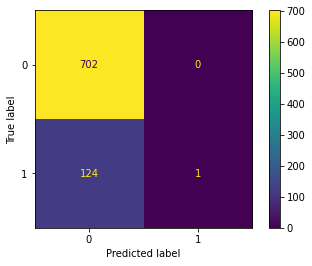

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

Printing ROC Curve: 


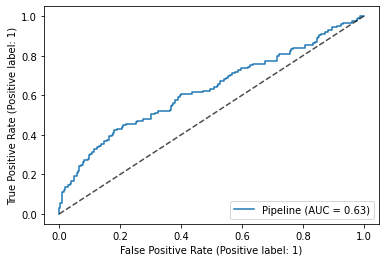

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(my_pipeline, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

**A very poor model indeed - especially on the minority class where recall is 0, every single patient except 1 have been classified as not having CHD in the next 10 years which is fatally incorrect**

In [ ]:
# Defining Parameter Grid
params_grid = {'model00__C': [0.01, 0.1, 1, 10, 100, 1000],
               'model00__kernel': ['sigmoid', 'rbf'],
               'model00__gamma': [1,0.1,0.01,0.001]}

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

#implementing a 3-fold stratified grid search, optimizing for F2
gs_model00 = GridSearchCV(estimator = my_pipeline, param_grid = params_grid, cv = s_cv, scoring= ftwo_scoring, verbose = 3)
gs_model00.fit(X_train, y_train)

print(gs_model00.best_score_, gs_model00.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END model00__C=0.01, model00__gamma=1, model00__kernel=sigmoid;, score=0.037 total time=   0.2s
[CV 2/3] END model00__C=0.01, model00__gamma=1, model00__kernel=sigmoid;, score=0.007 total time=   0.2s
[CV 3/3] END model00__C=0.01, model00__gamma=1, model00__kernel=sigmoid;, score=0.000 total time=   0.2s
[CV 1/3] END model00__C=0.01, model00__gamma=1, model00__kernel=rbf;, score=0.000 total time=   0.3s
[CV 2/3] END model00__C=0.01, model00__gamma=1, model00__kernel=rbf;, score=0.000 total time=   0.3s
[CV 3/3] END model00__C=0.01, model00__gamma=1, model00__kernel=rbf;, score=0.000 total time=   0.3s
[CV 1/3] END model00__C=0.01, model00__gamma=0.1, model00__kernel=sigmoid;, score=0.000 total time=   0.2s
[CV 2/3] END model00__C=0.01, model00__gamma=0.1, model00__kernel=sigmoid;, score=0.000 total time=   0.2s
[CV 3/3] END model00__C=0.01, model00__gamma=0.1, model00__kernel=sigmoid;, score=0.000 total time=   0.2s

**Best F2 Score and Hyperparameter Combination:0.2325579122639746 {'model00__C': 1000, 'model00__gamma': 0.01, 'model00__kernel': 'sigmoid'}**

This is a significant improvement over effectively a score of 0 for F2

In [ ]:
# getting predictions
y_predictions = gs_model00.predict(X_test)

**A great improvement once tuned, although not a great model**

In [ ]:
print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       702
           1       0.23      0.22      0.22       125

    accuracy                           0.77       827
   macro avg       0.54      0.54      0.54       827
weighted avg       0.77      0.77      0.77       827



**35 Less False Negatives**

Printing Confusion Matrix


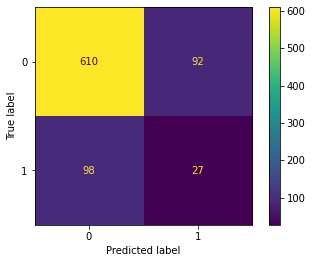

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

**However we have an extremely bad ROC Curve - whilst the model looked to have improved performance, albeit bad performance nonetheless, the curve and AUC suggest that this equivalent to random guessing suggesting a useless model, like the baseline**

**This model without sampling just cannot effectively distinguish classes, attributed to the lack of training points in the minority class**

Printing ROC Curve: 


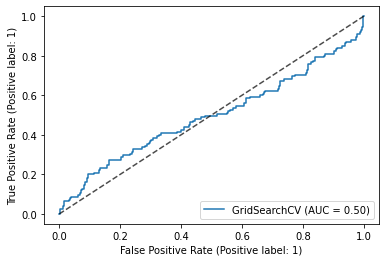

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(gs_model00, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

## Model 0.1 (NO OVER OR UNDERSAMPLING) - MLP Baseline + MLP Tuned

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [('scalings', StandardScaler()),
                                ('model01', MLPClassifier(random_state = 42))])

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Getting the expected generalization performance using cross validation:
scores = cross_val_score(my_pipeline, X_train, y_train, cv = s_cv, scoring = ftwo_scoring)

# Mean CV score and Standard Deviations of CV score for F2 score
mlp_base_cv_nos_mean = np.mean(scores)
mlp_base_cv_nos_sd = np.std(scores)

In [ ]:
print(mlp_base_cv_nos_mean, mlp_base_cv_nos_sd)

0.10298380150968052 0.034761669692776775


**Baseline MLP has slightly better performance at classifying minority class, but still rubbish, compared to baseline SVM**

In [ ]:
# Fitting Model to Training Data:
my_pipeline.fit(X_train, y_train)

# Getting Test Performance via Classification Report
y_predictions = my_pipeline.predict(X_test)

baseline_f2 = fbeta_score(y_test, y_predictions, beta = 2)

print('Baseline F2 Score on Test Set: ' + str(baseline_f2))
print('')

print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Baseline F2 Score on Test Set: 0.14097744360902256

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.92       702
           1       0.47      0.12      0.19       125

    accuracy                           0.85       827
   macro avg       0.67      0.55      0.55       827
weighted avg       0.80      0.85      0.81       827



**Slightly less false false negatives compared to baseline SVM**

Printing Confusion Matrix


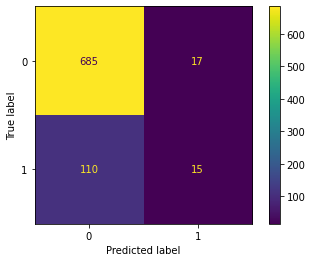

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

Printing ROC Curve: 


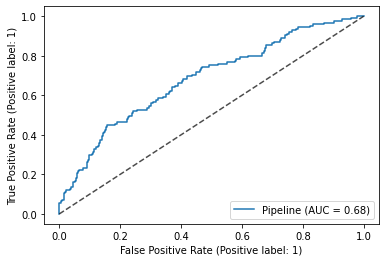

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(my_pipeline, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

In [ ]:
# Tuning

# Developing Pipeline
my_pipeline = Pipeline(steps = [('scalings', StandardScaler()),
                                ('model01', MLPClassifier(random_state = 42, solver = 'adam', activation = 'relu', tol = 1e-3, n_iter_no_change = 8,
                                                         max_iter = 2000, early_stopping = True, validation_fraction = 0.15))])

# Defining Parameter Grid
params_grid = {'model01__hidden_layer_sizes': [(10, ), (20, ), (50, ), (100, ), (150, )],
               'model01__batch_size': [64, 128],
               'model01__learning_rate_init': [0.1, 0.01, 0.001],
               'model01__momentum': [0, 0.5, 0.9]}

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

#implementing a 3-fold stratified grid search, optimizing for F2
gs_model01 = GridSearchCV(estimator = my_pipeline, param_grid = params_grid, cv = s_cv, scoring= ftwo_scoring, verbose = 3)
gs_model01.fit(X_train, y_train)

print(gs_model01.best_score_, gs_model01.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END model01__batch_size=64, model01__hidden_layer_sizes=(10,), model01__learning_rate_init=0.1, model01__momentum=0;, score=0.107 total time=   0.2s
[CV 2/3] END model01__batch_size=64, model01__hidden_layer_sizes=(10,), model01__learning_rate_init=0.1, model01__momentum=0;, score=0.058 total time=   0.2s
[CV 3/3] END model01__batch_size=64, model01__hidden_layer_sizes=(10,), model01__learning_rate_init=0.1, model01__momentum=0;, score=0.000 total time=   0.2s
[CV 1/3] END model01__batch_size=64, model01__hidden_layer_sizes=(10,), model01__learning_rate_init=0.1, model01__momentum=0.5;, score=0.107 total time=   0.2s
[CV 2/3] END model01__batch_size=64, model01__hidden_layer_sizes=(10,), model01__learning_rate_init=0.1, model01__momentum=0.5;, score=0.058 total time=   0.2s
[CV 3/3] END model01__batch_size=64, model01__hidden_layer_sizes=(10,), model01__learning_rate_init=0.1, model01__momentum=0.5;, score=0.000 tot

**Best F2 Score and Hyperparameter Combination:0.11291381643438607 {'model01__batch_size': 128, 'model01__hidden_layer_sizes': (50,), 'model01__learning_rate_init': 0.1, 'model01__momentum': 0}**

We actually get **worsened** performance after tuning, suggesting for the non-sampled version of the data, the default hyperparamters for the MLP model give what looks to be the best performance (although we haven't done an exhaustive search).

Therefore the above ROC curves and confusion matrices hold for the tuned version too.

## Model 1: Baseline SVM (With Sampling)

A baseline SVC uses a regularization of 1, with an RBF kernel and gamma calculated through scaling in which the calculation can be found via the documentation

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model_1', SVC())])

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Getting the expected generalization performance using cross validation:
scores = cross_val_score(my_pipeline, X_train, y_train, cv = s_cv, scoring = ftwo_scoring)

# Mean CV score and Standard Deviations of CV score for F2 score
svm_base_cv_mean = np.mean(scores)
svm_base_cv_sd = np.std(scores)

In [ ]:
print(svm_base_cv_mean, svm_base_cv_sd)

In [ ]:
# Fitting Model to Training Data:
my_pipeline.fit(X_train, y_train)

In [ ]:
# Getting Test Performance via Classification Report
y_predictions = my_pipeline.predict(X_test)

baseline_f2 = fbeta_score(y_test, y_predictions, beta = 2)

print('Baseline F2 Score on Test Set: ' + str(baseline_f2))
print('')

print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Baseline F2 Score on Test Set: 0.400262467191601

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.71      0.79       702
           1       0.23      0.49      0.32       125

    accuracy                           0.68       827
   macro avg       0.56      0.60      0.55       827
weighted avg       0.79      0.68      0.72       827



Printing Confusion Matrix


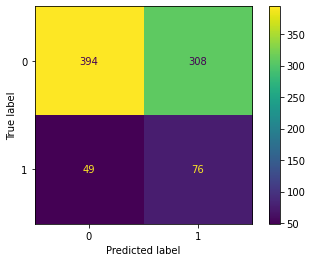

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

Printing ROC Curve: 


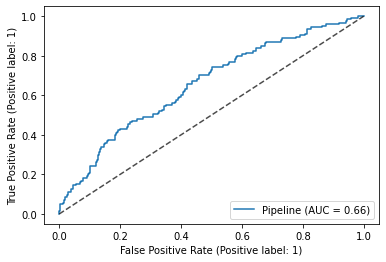

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(my_pipeline, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

 ## Model 2: Tuned SVM (With Sampling)

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model2', SVC())])

# Defining Parameter Grid
params_grid = {'model2__C': [0.01, 0.1, 1, 10, 100, 1000],
               'model2__kernel': ['linear', 'sigmoid', 'rbf'],
               'model2__gamma': [1,0.1,0.01,0.001]}

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

#implementing a 3-fold stratified grid search, optimizing for F2
gs_model2 = GridSearchCV(estimator = my_pipeline, param_grid = params_grid, cv = s_cv, scoring= ftwo_scoring, verbose = 3)
gs_model2.fit(X_train, y_train)

print(gs_model2.best_score_, gs_model2.best_params_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[CV 1/3] END model2__C=0.01, model2__gamma=1, model2__kernel=linear;, score=0.470 total time=   0.6s
[CV 2/3] END model2__C=0.01, model2__gamma=1, model2__kernel=linear;, score=0.486 total time=   0.6s
[CV 3/3] END model2__C=0.01, model2__gamma=1, model2__kernel=linear;, score=0.514 total time=   0.6s
[CV 1/3] END model2__C=0.01, model2__gamma=1, model2__kernel=sigmoid;, score=0.446 total time=   1.0s
[CV 2/3] END model2__C=0.01, model2__gamma=1, model2__kernel=sigmoid;, score=0.487 total time=   1.2s
[CV 3/3] END model2__C=0.01, model2__gamma=1, model2__kernel=sigmoid;, score=0.476 total time=   1.0s
[CV 1/3] END model2__C=0.01, model2__gamma=1, model2__kernel=rbf;, score=0.307 total time=   1.0s
[CV 2/3] END model2__C=0.01, model2__gamma=1, model2__kernel=rbf;, score=0.496 total time=   1.0s
[CV 3/3] END model2__C=0.01, model2__gamma=1, model2__kernel=rbf;, score=0.223 total time=   1.0s
[CV 1/3] END model2__C=0.01, model2

**Best F2 Score and Hyperparameter Combination: 0.49750725169924603 {'model2__C': 1, 'model2__gamma': 0.01, 'model2__kernel': 'sigmoid'}**

We effectively can achieve an F2 of 0.5, whilst not the best, it is clearly better than 0.4 with the baseline model

In [ ]:
# getting predictions
y_predictions = gs_model2.predict(X_test)

**We see below, as hoped much better improvement in the performance on the minority class**

In [ ]:
print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.66      0.77       702
           1       0.26      0.68      0.38       125

    accuracy                           0.66       827
   macro avg       0.59      0.67      0.57       827
weighted avg       0.82      0.66      0.71       827



**We also note the significant reduction in false negatives, although an increase in false positives which isn't anywhere near as problematic**

Printing Confusion Matrix


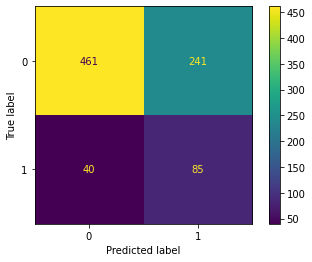

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

**We further see the slightly improved ROC curve with a higher AUC of 0.71**

Printing ROC Curve: 


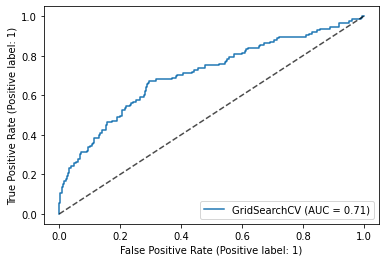

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(gs_model2, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

**Tuning using the polynomial kernel was also implemented, however was terminated and omitted after the grid search. approximately 80% of the way through this grid search, each of the 3 stages in 3 fold cross validation started taking several hours each which was infeasible - it was found that this occurred for large values of C**

## Model 3: Baseline MLP (With Sampling)

A baseline MLP in sklearn consists of a single hidden layer with 100 nodes, using the ReLU activation, Adam optimizer with a learning rate of 0.001 and a batch size of 100, momentum of 0.9 and tolerance of 1e-4 with a patience of 10 epochs (200 epochs max)

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model_3', MLPClassifier(random_state = 42))])

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

# Getting the expected generalization performance using cross validation:
scores = cross_val_score(my_pipeline, X_train, y_train, cv = s_cv, scoring = ftwo_scoring)

# Mean CV score and Standard Deviations of CV score for F2 score
mlp_base_cv_mean = np.mean(scores)
mlp_base_cv_sd = np.std(scores)

In [ ]:
print(mlp_base_cv_mean, mlp_base_cv_sd)

0.4188084904463132 0.00766638330480729


In [ ]:
# Fitting Model to Training Data:
my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', EditedNearestNeighbours()),
                ('smote',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8, 9, 14,
                                               15, 16],
                         random_state=42, sampling_strategy='not majority')),
                ('scalings', StandardScaler()),
                ('model_3', MLPClassifier(random_state=42))])

From below, the baseline MLP is **ever so slightly better**, with a roughly equivalent AUC

In [ ]:
# Getting Test Performance via Classification Report
y_predictions = my_pipeline.predict(X_test)

baseline_f2 = fbeta_score(y_test, y_predictions, beta = 2)

print('Baseline F2 Score on Test Set: ' + str(baseline_f2))
print('')

print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Baseline F2 Score on Test Set: 0.4128440366972477

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.72      0.79       702
           1       0.24      0.50      0.32       125

    accuracy                           0.68       827
   macro avg       0.56      0.61      0.56       827
weighted avg       0.79      0.68      0.72       827



Printing Confusion Matrix


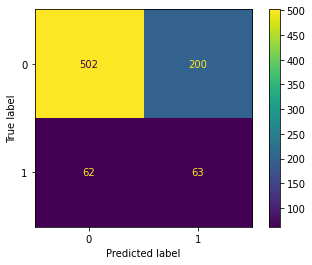

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

Printing ROC Curve: 


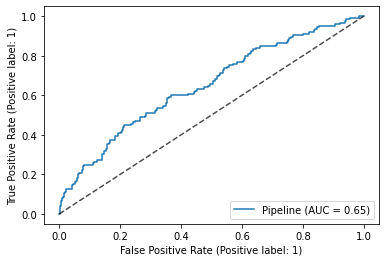

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(my_pipeline, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

## Model 4: Tuned MLP (With Sampling)

Given the sheer number of features, it is very likely that this data is not linearly separable, hence we require the presence of hidden layers.

This raises the question of how many.

Typically for the majority of problems can generate sufficient performance using one or two layers. This is what we'll test here. From an outsiders perspective, 2 layers at the maximum looks sufficient, anything over this is overkill, which can be difficult to train, can overfit and may only lead to marginal improvements.

For this project, it has been chosen to implement on a single layered MLP due to the sheer number of hyperparameters, which when using grid searches will take a long enough time as it is, before even moving on to 2 layered versions.

We keep the following hyperparameters fixed:
- Optimizer: Adam - this is a renowned optimizer and has had immense success in effectively training neural networks
- Activation Function: ReLU - There are tonnes of choices available, some good starting points are the sigmoid activation functions which are very powerful, but also many of the ReLU activation function variants (Leaky, ELU etc.) In particular, ReLU will be considered in the hidden layers - ReLU is simple to implement and can overcome many of the shortcomings exhibited by activations such as sigmoid of tanh i.e. it's less susceptible to the vanishing gradient problems which stop models from being training, however, it can suffer from problems such as saturated units.
- Tolerance: 0.001
- Patience: 8 epochs
- Max Epochs: 2000
- Dropout: 0 (unavailable in sklearn)

We tune the following hyperparameters:
- Number of Neurons: [5, 10, 20, 50, 100, 150], Whilst its clear that the default 100 neurons has decent performance, that's not to say we could achieve equivalent performance with significantly less. Hence an assortment of neurons below 100 has been tried, whilst trying on more combination over 100
- Batch Size: [64, 128]
- Learning Rate: [0.1, 0.01, 0.001]
- Momentum: [0, 0.5, 0.9]

Early Stopping is implemented within this grid search, in which a validation set it created using 15% of the training data which by default is stratified, this prevents over training which could lead to overfitting. Given the size of the data, training is expected to be completed, with early stopping, in roughly 1000 epochs or less, hence the buffer in which I set max epochs to be 2000

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model4', MLPClassifier(random_state = 42, solver = 'adam', activation = 'relu', tol = 1e-3, n_iter_no_change = 8,
                                                         max_iter = 2000, early_stopping = True, validation_fraction = 0.15))])

# Defining Parameter Grid
params_grid = {'model4__hidden_layer_sizes': [(10, ), (20, ), (50, ), (100, ), (150, )],
               'model4__batch_size': [64, 128],
               'model4__learning_rate_init': [0.1, 0.01, 0.001],
               'model4__momentum': [0, 0.5, 0.9]}

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

#implementing a 3-fold stratified grid search, optimizing for F2
gs_model4 = GridSearchCV(estimator = my_pipeline, param_grid = params_grid, cv = s_cv, scoring= ftwo_scoring, verbose = 3)
gs_model4.fit(X_train, y_train)

print(gs_model4.best_score_, gs_model4.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END model4__batch_size=64, model4__hidden_layer_sizes=(10,), model4__learning_rate_init=0.1, model4__momentum=0;, score=0.446 total time=   0.6s
[CV 2/3] END model4__batch_size=64, model4__hidden_layer_sizes=(10,), model4__learning_rate_init=0.1, model4__momentum=0;, score=0.415 total time=   1.0s
[CV 3/3] END model4__batch_size=64, model4__hidden_layer_sizes=(10,), model4__learning_rate_init=0.1, model4__momentum=0;, score=0.446 total time=   0.6s
[CV 1/3] END model4__batch_size=64, model4__hidden_layer_sizes=(10,), model4__learning_rate_init=0.1, model4__momentum=0.5;, score=0.446 total time=   0.6s
[CV 2/3] END model4__batch_size=64, model4__hidden_layer_sizes=(10,), model4__learning_rate_init=0.1, model4__momentum=0.5;, score=0.415 total time=   1.2s
[CV 3/3] END model4__batch_size=64, model4__hidden_layer_sizes=(10,), model4__learning_rate_init=0.1, model4__momentum=0.5;, score=0.446 total time=   0.7s
[CV 1/3]

**Best F2 Score and Hyperparameter Combination: 0.47961418234348113 {'model4__batch_size': 128, 'model4__hidden_layer_sizes': (100,), 'model4__learning_rate_init': 0.001, 'model4__momentum': 0}**

We effectively can achieve an F2 of 0.48, whilst not the best, it is clearly better than 0.41 with the baseline model, however we see that the tuned SVM model does outperform this slightly

In [ ]:
# getting predictions
y_predictions = gs_model4.predict(X_test)

**As hoped, an improvement over the baseline**

In [ ]:
print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.68      0.78       702
           1       0.26      0.63      0.37       125

    accuracy                           0.67       827
   macro avg       0.58      0.65      0.57       827
weighted avg       0.81      0.67      0.71       827



**We see our reduction in false negatives!**

Printing Confusion Matrix


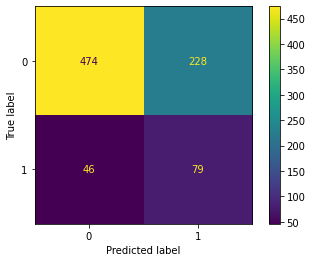

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

**An improved ROC over the baseline, though slightly under compared to the SVM**

Printing ROC Curve: 


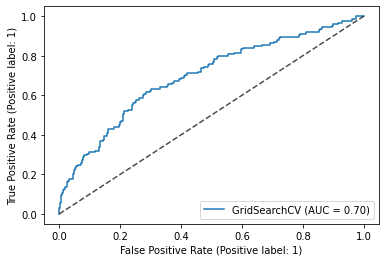

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(gs_model4, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

## Model (5): Tuned MLP with 2 Hidden Layers (With Sampling) - INTERMEDIATE IMPLEMENTATION

As an aside, a two layer MLP is tuned in which there is the same number of hidden neurons in each layer.

It would be interesting to see how this performs in comparison

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model5', MLPClassifier(random_state = 42, solver = 'adam', activation = 'relu', tol = 1e-3, n_iter_no_change = 8,
                                                         max_iter = 2000, early_stopping = True, validation_fraction = 0.15))])

# Defining Parameter Grid
params_grid = {'model5__hidden_layer_sizes': [(10, 10), (20, 20), (50, 50), (100, 100), (150, 150)],
               'model5__batch_size': [64, 128],
               'model5__learning_rate_init': [0.1, 0.01, 0.001],
               'model5__momentum': [0, 0.5, 0.9]}

# Developing Scoring
ftwo_scoring = make_scorer(fbeta_score, beta = 2)

# Developing Cross Validation Object for Scoring in Cross Validation
s_cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)

#implementing a 3-fold stratified grid search, optimizing for F2
gs_model5 = GridSearchCV(estimator = my_pipeline, param_grid = params_grid, cv = s_cv, scoring= ftwo_scoring, verbose = 3)
gs_model5.fit(X_train, y_train)

print(gs_model5.best_score_, gs_model5.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3] END model5__batch_size=64, model5__hidden_layer_sizes=(10, 10), model5__learning_rate_init=0.1, model5__momentum=0;, score=0.434 total time=   1.7s
[CV 2/3] END model5__batch_size=64, model5__hidden_layer_sizes=(10, 10), model5__learning_rate_init=0.1, model5__momentum=0;, score=0.409 total time=   1.5s
[CV 3/3] END model5__batch_size=64, model5__hidden_layer_sizes=(10, 10), model5__learning_rate_init=0.1, model5__momentum=0;, score=0.392 total time=   1.3s
[CV 1/3] END model5__batch_size=64, model5__hidden_layer_sizes=(10, 10), model5__learning_rate_init=0.1, model5__momentum=0.5;, score=0.434 total time=   1.1s
[CV 2/3] END model5__batch_size=64, model5__hidden_layer_sizes=(10, 10), model5__learning_rate_init=0.1, model5__momentum=0.5;, score=0.409 total time=   1.3s
[CV 3/3] END model5__batch_size=64, model5__hidden_layer_sizes=(10, 10), model5__learning_rate_init=0.1, model5__momentum=0.5;, score=0.392 total tim

**This is an improvement over its single layered counterpart, although surprisingly stil cannot perform as well as the tuned SVM model**

In [ ]:
# getting predictions
y_predictions = gs_model5.predict(X_test)

In [ ]:
print('Printing Classification Report:')
print(classification_report(y_test, y_predictions))

Printing Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.59      0.72       702
           1       0.23      0.68      0.34       125

    accuracy                           0.60       827
   macro avg       0.57      0.63      0.53       827
weighted avg       0.81      0.60      0.66       827



Printing Confusion Matrix


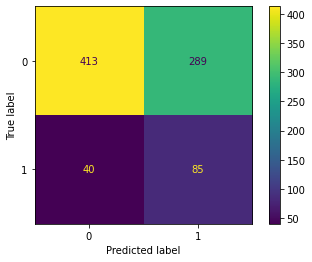

In [ ]:
# Getting Confusion Matrix
print('Printing Confusion Matrix')
cm = confusion_matrix(y_test, y_predictions)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot()
plt.show()

Printing ROC Curve: 


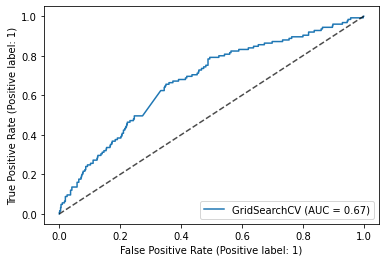

In [ ]:
print('Printing ROC Curve: ')
plot_roc_curve(gs_model5, X_test, y_test) 
plt.plot([0,1],[0,1],"--",color="k",alpha=0.7)
plt.show()

## Model Extracting (Pickling)

In [ ]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model2', SVC(C = 1, gamma = 0.01, kernel = 'sigmoid'))])

my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', EditedNearestNeighbours()),
                ('smote',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8, 9, 14,
                                               15, 16],
                         random_state=42, sampling_strategy='not majority')),
                ('scalings', StandardScaler()),
                ('model2', SVC(C=1, gamma=0.01, kernel='sigmoid'))])

In [ ]:
# We now export this tuned model: 
import pickle

with open("best_svm.pkl", "wb") as best_svm:
    pickle.dump(my_pipeline, best_svm)

In [16]:
# Developing Pipeline
my_pipeline = Pipeline(steps = [ ('undersample', EditedNearestNeighbours(sampling_strategy = 'auto', kind_sel='all')),
                                ('smote', SMOTENC(random_state = 42, categorical_features = [0,2,3,4,5,6,7,8,9,14,15,16], sampling_strategy='not majority')),
                                ('scalings', StandardScaler()),
                                ('model4', MLPClassifier(random_state = 42, solver = 'adam', activation = 'relu', tol = 1e-3, n_iter_no_change = 8,
                                                         max_iter = 2000, early_stopping = True, validation_fraction = 0.15,
                                                         batch_size = 128, hidden_layer_sizes = (100,), learning_rate_init = 0.001, momentum = 0))])

my_pipeline.fit(X_train, y_train)

Pipeline(steps=[('undersample', EditedNearestNeighbours()),
                ('smote',
                 SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 7, 8, 9, 14,
                                               15, 16],
                         random_state=42, sampling_strategy='not majority')),
                ('scalings', StandardScaler()),
                ('model4',
                 MLPClassifier(batch_size=128, early_stopping=True,
                               max_iter=2000, momentum=0, n_iter_no_change=8,
                               random_state=42, tol=0.001,
                               validation_fraction=0.15))])

In [ ]:
# We now export this tuned model: 
import pickle

with open("best_mlp.pkl", "wb") as best_mlp:
    pickle.dump(my_pipeline, best_mlp)